<a href="https://colab.research.google.com/github/R12942159/NTU_DLCV/blob/Hw3/p1_CLIP_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

In [26]:
import os
import csv
import json
import clip
import torch
import random
import pathlib
import argparse
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from google.colab import drive

#### Get cuda from GPU device.

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


#### Connect google drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


#### Download dataset and unzip zip file.

In [ ]:
!gdown 11rP6KmR5Qwjhx0rfag0b5TZGBTRuPtQR -O hw3_data.zip
!unzip /content/hw3_data.zip

#### Construct image path

In [59]:
val_path = '/content/hw3_data/p1_data/val'
id2label_path = '/content/hw3_data/p1_data/id2label.json'
output_path = '/content/hw3_data'

img_paths = [os.path.join(val_path, i) for i in os.listdir(val_path) if i.endswith('.png')]
id2label = json.load(open(id2label_path, 'r'))
labels = [l for _, l in id2label.items()]

#### Training with ["RN50"(49.88%), "RN101"(50.92%), "RN50x4"(43.68%), "RN50x16"(58.72%), "RN50x64"(62.05%), "ViT-B/32"(71.16%), "ViT-B/16"(74.6%), "ViT-L/14"(81.44%), "ViT-L/14@336px"(80.68%)]

In [140]:
def train(model_name = "ViT-L/14"):
    model, transform = clip.load(name=model_name, device=device, jit=False)

    rd_sample = random.sample(list(range(2500)), 3)

    for i in rd_sample:
        path = img_paths[i]
        gt = path.split('/')[-1].split('_')[0]

        img = Image.open(path).convert('RGB')
        img = transform(img).unsqueeze(0).to(device) #  # resize to (1, 3, 448, 448), expected 4D input
        prompt_text = torch.cat(
            [clip.tokenize(f'A photo of a {i}.', context_length=77, truncate=False) for i in labels]
        ).to(device)

        with torch.no_grad():
            img_features = model.encode_image(img) # (1, 1024)
            text_features = model.encode_text(prompt_text) # (50, 1024)

        # Pick the top 5 most similar labels for the image
        img_features /= img_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100. * img_features @ text_features.T).softmax(dim=-1)

        gt_prob = similarity[0][int(gt)]
        values, indices = similarity[0].topk(5)
        values = values.cpu().numpy() * 100
        indices = indices .cpu().numpy()

        # Plot top-5 similarity scores
        img = Image.open(path).convert('RGB')
        fig, xs = plt.subplots(1, 2, figsize=(10, 5))

        xs[0].imshow(img)
        xs[0].set_title(
            f'This is the image of {i}th, it is a {id2label[gt]}.',
            fontsize=12,
        )

        sns.barplot(
            x=values,
            y=[f'a photo of a {labels[j]}.' for j in indices],
            orient='h',
            ax=xs[1],
            palette=sns.color_palette("husl", 5),
            errwidth=1.5,
            dodge=False,
            **{'linewidth': 0},
        )
        xs[1].tick_params(axis="y", direction="in", pad=-100, labelsize=8)
        xs[1].set(
            xlim=[0, 100],
            title=f'The prob. of {id2label[gt]} is {gt_prob*100:.4f}%',
        )

        plt.savefig(f'/content/drive/MyDrive/NTU_DLCV/Hw3/p1_plot/{i}plot')

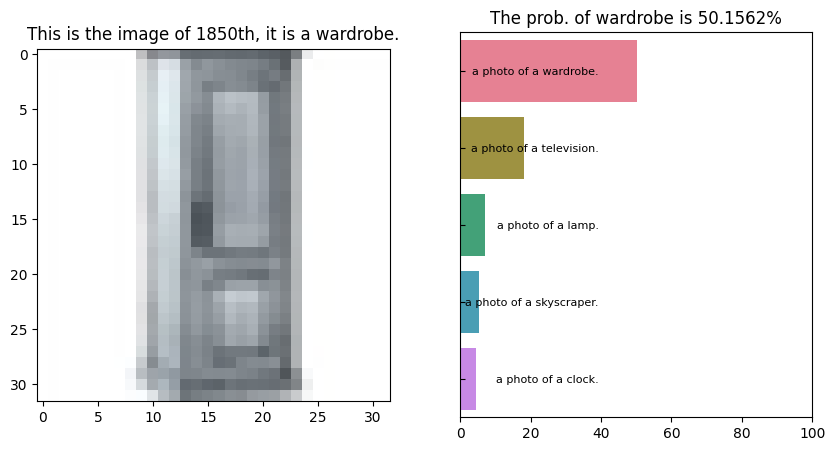

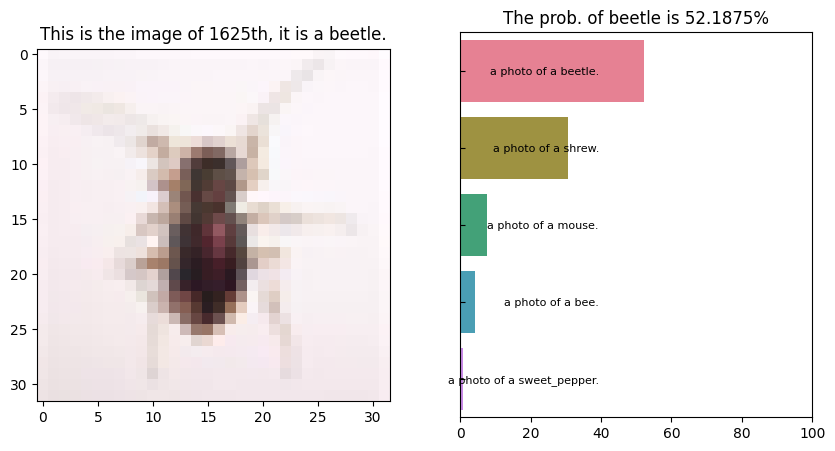

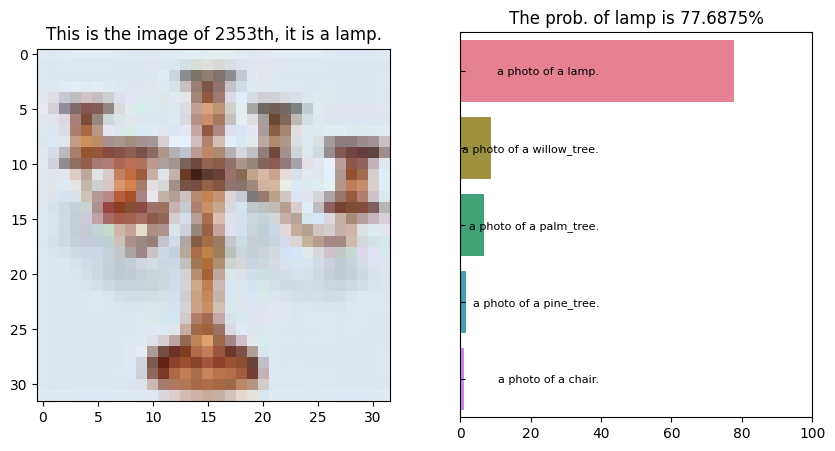

In [142]:
train()